<IPython.core.display.Math object>

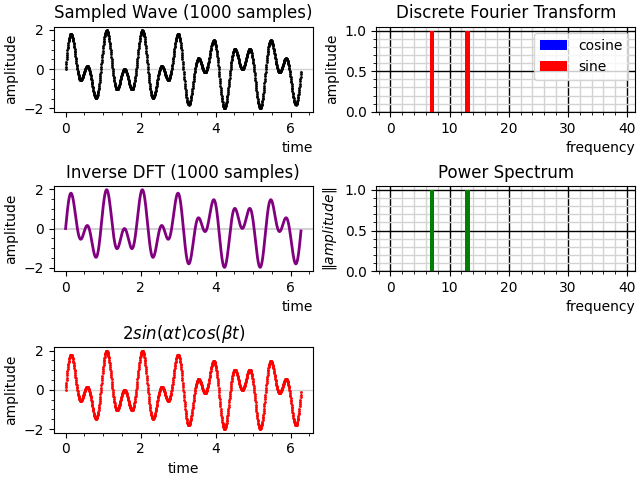

In [1]:
"""unknown_wave.ipynb"""
# Cell 1: Plot the sampled data, Fourier transform (DFT), IDFT, and power spectrum as in fourier_discrete.ipynb 
# Also calculate and display alpha and beta given that the unknown wave has form 2sin(⍺t)cos(ßt), and 
# recreate the original data by plotting 2sin(⍺t)cos(ßt) using calculated alpha and beta values.

# Based on @dbiersach, fourier_discrete.ipynb:
# https://github.com/dbiersach/qis101/blob/0aa4537a02ac7f71d62ce6bbaf54e1e3175a5d51/labs/Session%2013%20-%20Fourier%20Analysis/fourier_discrete.ipynb


# Imports
from __future__ import annotations

import typing

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from IPython.core.display import Math

if typing.TYPE_CHECKING:
    from matplotlib.axes import Axes
    from numpy.typing import NDArray

%matplotlib widget

# Define maximum frequency to be plotted on Fourier Transform graphs
max_freq: int = 40

# fmt: off

def dft(ts: NDArray[np.float_],
        ys: NDArray[np.float_]
    )-> tuple[NDArray[np.float_], NDArray[np.float_], NDArray[np.int_], NDArray[np.int_]]:
    """Calculate and return arrays of cosine and sine amplitudes and frequencies using Discrete Fourier Transform"""

    num_samples: int = ts.size
    num_terms: int = int(num_samples / 2)  # Nyquist limit

    # Prepare arrays for amplitudes
    a_cos: NDArray[np.float_] = np.zeros(num_terms)
    b_sin: NDArray[np.float_] = np.zeros(num_terms)

    # Create empty arrays to store frequencies present in the unknown wave
    # Array for frequencies corresponding to a cosine term
    cos_frequencies: NDArray[np.int_] = np.asarray([])
    # Array for frequencies corresponding to a sine term
    sin_frequencies: NDArray[np.int_] = np.asarray([])

    for term in range(0, num_terms):
        # Accumulators
        a: float = 0.0
        b: float = 0.0
        # Calculate amplitudes using Fourier formulas
        for sample in range(0, num_samples):
            a += 2 * np.cos(term * ts[sample]) * ys[sample]
            b += 2 * np.sin(term * ts[sample]) * ys[sample]
        a_cos[term] = round(a / num_samples, 8) + 0
        b_sin[term] = round(b / num_samples, 8) + 0
        # Append frequency ("term") to cosine/sine frequencies list if the corresponding frequency & phase is present in the wave
        if a_cos[term] > 0: 
            cos_frequencies = np.append(cos_frequencies, term)
        if b_sin[term] > 0:
            sin_frequencies = np.append(sin_frequencies, term)

    # First elements of a_cos and b_cos were not supposed to be multiplied by 2
    # a_cos[0] is the avg value (offset) of the function
    a_cos[0] /= 2
    b_sin[0] /= 2

    return a_cos, b_sin, cos_frequencies, sin_frequencies


def idft(a_cos: NDArray[np.float_], b_sin: NDArray[np.float_],
         ts: NDArray[np.float_]) -> NDArray[np.float_]:
    """Reconstruct original data using the Inverse Discrete Fourier Transform"""
    num_terms: int = a_cos.size
    # Number of samples in csv
    num_points: int = ts.size
    yr: NDArray[np.float_] = np.zeros(num_points)

    # Recreate original y values
    for point in range(0, num_points):
        for term in range(0, num_terms):
            yr[point] += a_cos[term] * np.cos(term * ts[point]) + b_sin[term] * np.sin(
                term * ts[point]
            )

    return yr


def power_spec(a_cos: NDArray[np.float_],
               b_sin: NDArray[np.float_]) -> NDArray[np.float_]:
    """Calculate and return values for the power spectrum of the wave"""
    num_terms: int = a_cos.size
    ps: NDArray[np.float_] = np.zeros(num_terms, dtype=np.float_)
    for term in range(0, num_terms):
        ps[term] = np.sqrt(a_cos[term] ** 2 + b_sin[term] ** 2)
    return ps

# fmt: on


def plot_samples(ts: NDArray[np.float_], ys: NDArray[np.float_], ax: Axes) -> None:
    """Plot the original sampled wave"""
    
    ax.set_title(f"Sampled Wave ({ts.size} samples)")

    ax.set_xlabel("time", loc="right")
    ax.set_ylabel("amplitude")

    ax.axhline(y=0.0, color="lightgray", linewidth=1)

    # Plot values from the .csv file
    # fmt: off
    ax.plot(ts, ys, color="lightgray",
            marker="o", markerfacecolor="none",
            markersize=1, markeredgecolor="black")
    # fmt: on

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_dft(a_cos: NDArray[np.float_], b_sin: NDArray[np.float_], ax: Axes) -> None:
    """Plot the Discrete Fourier Transform for the data"""
    ax.set_title("Discrete Fourier Transform")

    ax.set_xlabel("frequency", loc="right")
    ax.set_ylabel("amplitude")

    highest_freq: int
    if max_freq:
        highest_freq = max_freq
    else:
        highest_freq = (
            max(int(np.amax(np.nonzero(a_cos))), int(np.amax(np.nonzero(b_sin)))) + 1
        )

    # fmt: off

    # Add bars corresponding to sine and cosine terms of the simplified wave equation
    ax.bar(range(0, highest_freq), a_cos[:highest_freq],
           label="cosine", color="blue", zorder=2)
    
    ax.bar(range(0, highest_freq), b_sin[:highest_freq],
           label="sine", color="red", zorder=2)

    # fmt: on

    ax.legend(loc="best")

    ax.grid(which="major", axis="x", color="black", linewidth=1)
    ax.grid(which="minor", axis="x", color="lightgray", linewidth=1)
    ax.grid(which="major", axis="y", color="black", linewidth=1)
    ax.grid(which="minor", axis="y", color="lightgray", linewidth=1)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_idft(ts: NDArray[np.float_], yr: NDArray[np.float_], ax: Axes) -> None:
    """Plot the Inverse Discrete Fourier Transform of the data (show recreated original data)"""
    ax.set_title(f"Inverse DFT ({ts.size} samples)")

    ax.set_xlabel("time", loc="right")
    ax.set_ylabel("amplitude")

    ax.axhline(y=0.0, color="lightgray")

    ax.plot(ts, yr, color="purple", linewidth=2)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_powerspec(ps: NDArray[np.float_], ax: Axes) -> None:
    """Plot the power spectrum for the data"""
    ax.set_title("Power Spectrum")

    ax.set_xlabel("frequency", loc="right")
    ax.set_ylabel(r"$\Vert amplitude \Vert$")

    highest_freq: int
    if max_freq:
        highest_freq = max_freq
    else:
        highest_freq = int(np.amax(np.nonzero(ps))) + 1

    # Create bar chart using values from power spectrum function
    ax.bar(range(0, highest_freq), ps[:highest_freq], color="green", zorder=2)

    ax.grid(which="major", axis="x", color="black", linewidth=1)
    ax.grid(which="minor", axis="x", color="lightgray", linewidth=1)
    ax.grid(which="major", axis="y", color="black", linewidth=1)
    ax.grid(which="minor", axis="y", color="lightgray", linewidth=1)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_alpha_beta_wave(ts: NDArray[np.float_], alpha_beta_wave: NDArray[np.float], ax: Axes) -> None:
    """Recreate and plot the original wave using calculated alpha and beta values substituted into
    given wave equation"""

    # Set titles and labels
    ax.set_title(r"$2sin(\alpha t)cos(\beta t)$")

    ax.set_xlabel("time")
    ax.set_ylabel("amplitude")
    ax.axhline(y=0.0, color="lightgray", linewidth=1)

    # Plot the reconstructed data
    ax.plot(ts, alpha_beta_wave, color="lightgray",
            marker="o", markerfacecolor="none",
            markersize=1, markeredgecolor="red")

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    


def analyze(file_name: str) -> None:
    """Perform the Fourier Transform on data points from a .csv file and output plots of the original wave, the 
    DFT, the IDFT, the power spectrum, and reconstructed data using calculated alpha and beta values"""
    
    # Generate a numpy array from a data file
    samples: NDArray[np.float_] = np.genfromtxt(file_name, delimiter=",")
    # Use array slicing to separate time and y columns into new arrays
    ts: NDArray[np.float_] = samples[:, 0] # Get all elements of the row, but only the first column
    ys: NDArray[np.float_] = samples[:, 1]

    # Type hints for a tuple
    a_cos: NDArray[np.float_]
    b_sin: NDArray[np.float_]
    cos_frequencies: NDArray[np.int_]
    sin_frequencies: NDArray[np.int_]
    # Pass data into dft function to find amplitudes and frequencies for components of the unknown wave
    a_cos, b_sin, cos_frequencies, sin_frequencies = dft(ts, ys) 
    # Reconstructed data values for the IDFT plot
    yr: NDArray[np.float_] = idft(a_cos, b_sin, ts)
    # Power spectrum
    ps: NDArray[np.float_] = power_spec(a_cos, b_sin)

    # Used Product-to-Sum formula for sin(u)cos(v) to break down 
    # given wave form 2sin(⍺t)cos(ßt) into a sum of two sinusoids:
    # sin((⍺+ß)t) + sin((⍺-ß)t)

    # Find alpha using the two sine frequencies stored in sin_frequencies
    # alpha = (freq 1 + freq 2) / 2
    alpha: int = (sin_frequencies[0] + sin_frequencies[1]) / 2
    
    # Find the positive beta value using alpha
    # beta = alpha - smallest freq
    beta: int = 0
    if (alpha - sin_frequencies[0]) < 0:
        beta = alpha - sin_frequencies[1]
    else:
        beta = alpha - sin_frequencies[0]

    # Print alpha and beta values
    display(Math(rf"\alpha = {alpha}, \beta = {beta}"))

    # Recreate original data using alpha and beta values
    alpha_beta_wave: NDArray[np.float_] = 2 * np.sin(alpha * ts) * np.cos(beta * ts)

    plt.close("all")
    plt.figure(file_name, constrained_layout=True)

    # Use multiple plots on the same figure
    # (#rows #cols #index)
    # Substitute alpha and beta into given wave equation and plot
    plot_alpha_beta_wave(ts, alpha_beta_wave, plt.subplot(325))
    # Plot original wave data
    plot_samples(ts, ys, plt.subplot(321))
    # Plot amplitude vs frequency from the DFT
    plot_dft(a_cos, b_sin, plt.subplot(322))
    # Plot reconstructed data (IDFT)
    plot_idft(ts, yr, plt.subplot(323))
    # Plot power spectrum
    plot_powerspec(ps, plt.subplot(324))

    plt.show()
        
  
# Put in name of file to analyze
analyze("unknown_wave.csv")
